In [57]:
from src.neighborhood_message_passing import NeighborhoodMessagePassing

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', size=12)
%matplotlib inline

In [58]:

g = nx.karate_club_graph()
r = 1
infection_rate = 0.2
t_max = 50
T = 10

## Influence maximization

In [59]:
n = len(g)
seeds = [0,10]

# set s and v
s = np.zeros(n)
s[seeds] = 1
# no vaccinated nodes
v = np.zeros(n)

NMP = NeighborhoodMessagePassing(g, r, infection_rate, t_max, 
                                    T=T, v = v, verbose=True, temporal = False)

NMP.neighborhood_message_passing(s)
marginals = NMP.marginals

Constructing neighborhoods for N_i excluding N_j.


100%|██████████| 34/34 [00:00<00:00, 26132.74it/s]


Sampling neighborhoods for marginal calculations.


100%|██████████| 34/34 [00:00<00:00, 457.04it/s]


Sampling neighborhoods for N_i excluding N_j.


 37%|███▋      | 18/49 [00:01<00:02, 11.15it/s]


In [60]:
# extract the expected outbreak size
pi_t = np.sum(marginals, axis=0)
print("Influence maximization",pi_t)

Influence maximization [ 2.          6.45841845  7.86277181  9.21515794  9.8168107  10.04476869
 10.1481024  10.21521355 10.2509104  10.26632878 10.27339769 10.27729261
 10.27936445 10.28033378 10.28078947 10.2810252  10.28114779 10.28120745
 10.28123613 10.28125056]


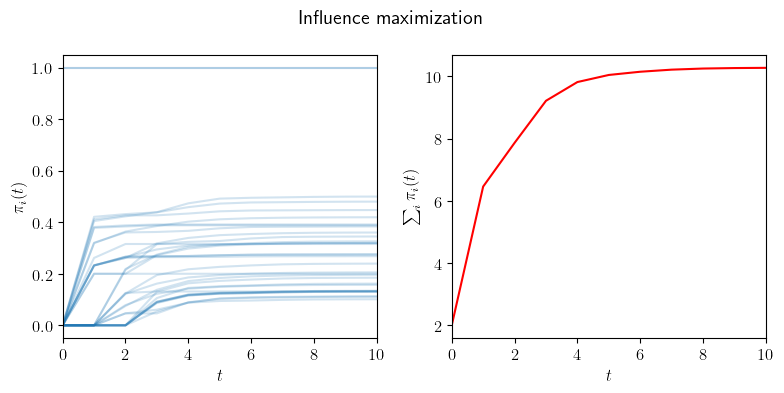

In [61]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax = axes[0]
ax.plot(marginals.T,color = 'C0', alpha = 0.2)
ax.set(xlabel=r'$t$', ylabel= r'$\pi_i(t)$',xlim=[0,10])

ax = axes[1]
ax.plot(pi_t, color = 'red')
ax.set(xlabel=r'$t$', ylabel= r'$\sum_i \pi_i(t)$')
ax.set(xlim=[0,10])
plt.suptitle("Influence maximization")
plt.tight_layout()

## Vaccination

In [62]:
n = len(g)
seeds = [0,10]

# set s and v
v = np.zeros(n)
for i in seeds:
    v[i] = 1
s = np.zeros(n)
s += 1/(n-len(seeds))
s[list(seeds)] = 0

# run NMP
NMP = NeighborhoodMessagePassing(g, r, infection_rate, t_max, T=T, v = v, temporal = False, verbose=False)
NMP.neighborhood_message_passing(s)
marginals = NMP.marginals

In [63]:
# extract the expected outbreak size
pi_t = np.sum(marginals, axis=0)
print("Vaccination",pi_t)

Vaccination [1.         1.83448029 2.68049001 3.00007445 3.19138142 3.28671106
 3.34972185 3.38030314 3.39670119 3.40531781 3.41036881 3.41302634
 3.41443583 3.41518769 3.41560877 3.41583551 3.4159565  3.41602138
 3.416057   3.4160763  3.41608666]


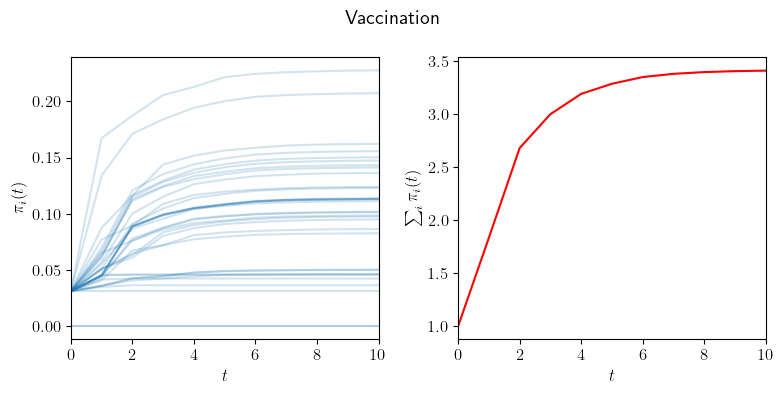

In [64]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax = axes[0]
ax.plot(marginals.T,color = 'C0', alpha = 0.2)
ax.set(xlabel=r'$t$', ylabel= r'$\pi_i(t)$',xlim=[0,10])

ax = axes[1]
ax.plot(pi_t, color = 'red')
ax.set(xlabel=r'$t$', ylabel= r'$\sum_i \pi_i(t)$')
ax.set(xlim=[0,10])
plt.suptitle("Vaccination")
plt.tight_layout()

## Sentinel Surveillance


In [65]:
n = len(g)
seeds = [0,10]

# set s and v
v = np.zeros(n)
for i in seeds:
    v[i] = 1
s = np.zeros(n)
s += 1/n

NMP = NeighborhoodMessagePassing(g, r, infection_rate, t_max, T=T, v = v, verbose=False, temporal = True)
NMP.neighborhood_message_passing(s,track_vaccinated=True)
marginals = NMP.marginals

In [66]:
marginals_S = marginals[seeds,:]
pi_S_t = 1 - np.prod(1-marginals_S, axis=0)
print("Sentinel surveillance",pi_S_t)

Sentinel surveillance [0.05795848 0.16034122 0.21942277 0.27063755 0.2967411  0.3136251
 0.32545887 0.33328243 0.33870451 0.34224079 0.34454059 0.34606326
 0.34707535 0.34774189 0.34818215 0.34847217 0.34866379 0.34879031
 0.34887381 0.34892893 0.3489653  0.34898931 0.34900516 0.34901563
 0.34902253 0.34902709 0.3490301  0.34903209 0.3490334  0.34903426
 0.34903484]


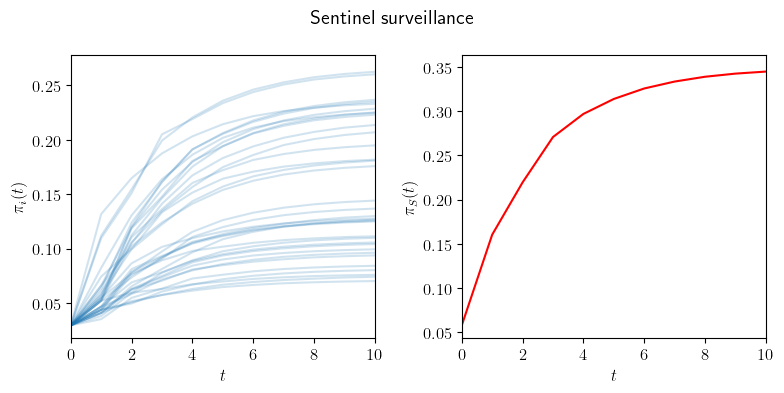

In [67]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

ax = axes[0]
ax.plot(marginals.T,color = 'C0', alpha = 0.2)
ax.set(xlabel=r'$t$', ylabel= r'$\pi_i(t)$',xlim=[0,10])

ax = axes[1]
ax.plot(pi_S_t, color = 'red')
ax.set(xlabel=r'$t$', ylabel= r'$\pi_S(t)$')
ax.set(xlim=[0,10])
plt.suptitle("Sentinel surveillance")
plt.tight_layout()

# Varying hyperparameters

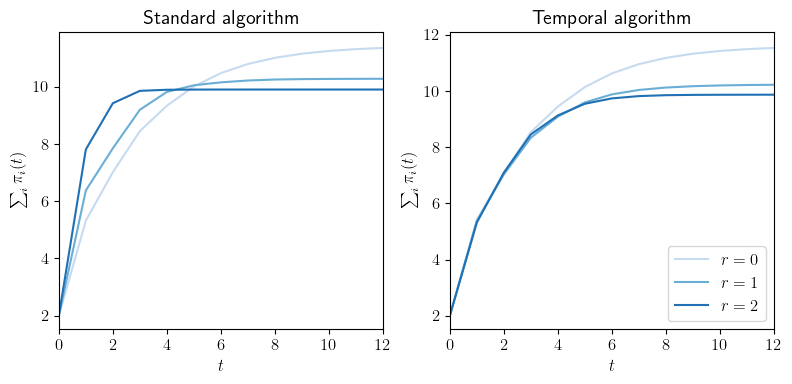

In [75]:
fig, axes = plt.subplots(1,2, figsize=(8,4))

for r in [0,1,2]:
    
    n = len(g)
    seeds = [0,10]

    # set s and v
    s = np.zeros(n)
    s[seeds] = 1
    # no vaccinated nodes
    v = np.zeros(n)

    NMP = NeighborhoodMessagePassing(g, r, infection_rate, t_max, 
                                        T=T, v = v, verbose=False, temporal = False)

    NMP.neighborhood_message_passing(s)
    marginals = NMP.marginals
    pi_t = np.sum(marginals, axis=0)
    if len(pi_t) < 16:
        pi_t = np.concatenate([pi_t,[pi_t[-1]]*(16-len(pi_t))])

    axes[0].plot(pi_t, label = r'$r = {}$'.format(r), color=plt.get_cmap('Blues')((r+1)/4))

    NMP = NeighborhoodMessagePassing(g, r, infection_rate, t_max, 
                                        T=200, v = v, verbose=False, temporal = True)

    NMP.neighborhood_message_passing(s)
    marginals = NMP.marginals
    pi_t = np.sum(marginals, axis=0)
    if len(pi_t) < 15:
        pi_t = np.concatenate([pi_t,[pi_t[-1]]*(15-len(pi_t))])

    axes[1].plot(pi_t, label = r'$r = {}$'.format(r), color=plt.get_cmap('Blues')((r+1)/4))

for ax in axes:
    ax.set(xlim=[0,12], xlabel=r'$t$', ylabel= r'$\sum_i \pi_i(t)$')

axes[0].set_title("Standard algorithm")
axes[1].set_title("Temporal algorithm")

ax.legend()
plt.tight_layout()